In [ ]:
import pandas_datareader as pdr
# !pip install yfinance
import yfinance as yf
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [ ]:
user_input = input("Enter Stock Symbol: ")

if not user_input:
  symbol = 'WIPRO.NS'         # Taken as an example
else:
  symbol = user_input

try:
    df = yf.download(symbol, start='2013-01-01', end='2021-05-29')

except:
    print("Stock Symbol is Invalid.")
    exit()

df.to_csv("data_prediction.csv")

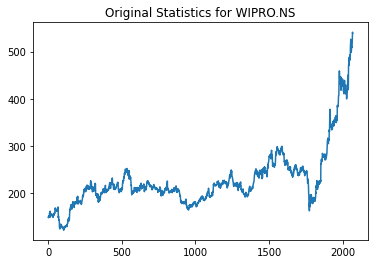

In [ ]:
df1 = df.reset_index()['Close']
plt.title("Original Statistics for "+str(symbol))
plt.plot(df1)         # X-axis: Days |||| Y-axis: Price

In [ ]:
df1.shape

(2069,)

In [ ]:
# LSTM is sensitive to scale of data. Hence, we apply MinMax scalar here.
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
df1.shape       # Got transformed and converted to array

(2069, 1)

In [ ]:
# print(df1)
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [ ]:
training_size, test_size

(1344, 725)

In [ ]:
len(train_data), len(test_data)

(1344, 725)

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(ytest.shape)

(1243, 100)
(1243,)
(624, 100)
(624,)


(None, None)

In [ ]:

# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))     # Because this is STACKED LSTM (one LSTM over another)
model.add(LSTM(50))                           # Because this is STACKED LSTM
model.add(Dense(1))                           # Final output
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_10 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 [==============================] - 9s 231ms/step - loss: 0.0059 - val_loss: 0.0189
Epoch 2/100
20/20 [==============================] - 4s 176ms/step - loss: 0.0011 - val_loss: 0.0168
Epoch 3/100
20/20 [==============================] - 4s 177ms/step - loss: 6.4387e-04 - val_loss: 0.0111
Epoch 4/100
20/20 [==============================] - 4s 183ms/step - loss: 4.1046e-04 - val_loss: 0.0052
Epoch 5/100
20/20 [==============================] - 4s 181ms/step - loss: 3.6626e-04 - val_loss: 0.0046
Epoch 6/100
20/20 [==============================] - 4s 184ms/step - loss: 3.5116e-04 - val_loss: 0.0047
Epoch 7/100
20/20 [==============================] - 4s 181ms/step - loss: 3.3387e-04 - val_loss: 0.0041
Epoch 8/100
20/20 [==============================] - 4s 181ms/step - loss: 3.2481e-04 - val_loss: 0.0041
Epoch 9/100
20/20 [==============================] - 4s 185ms/step - loss: 3.1605e-04 - val_loss: 0.0035
Epoch 10/100
20/20 [==============================] - 4s 186ms/

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

203.37808678450085

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

290.63555352069136

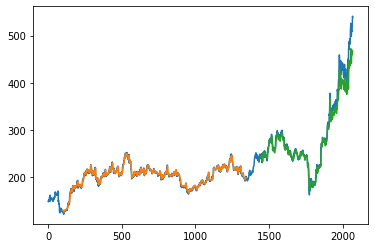

In [ ]:
### Plotting
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
len(test_data)

725

In [ ]:
temp = len(test_data)-100
temp

625

In [ ]:
x_input=test_data[temp:].reshape(1,-1)
x_input.shape

(1, 100)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
# temp_input

In [ ]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1



101
1 day output [[0.7406867]]
2 day output [[0.6187772]]
3 day output [[0.5247586]]
4 day output [[0.46893233]]
5 day output [[0.44820446]]
6 day output [[0.45168802]]
7 day output [[0.46661296]]
8 day output [[0.4818964]]
9 day output [[0.48948407]]
10 day output [[0.48490453]]
11 day output [[0.46743232]]
12 day output [[0.43963847]]
13 day output [[0.40625837]]
14 day output [[0.37264067]]
15 day output [[0.34325072]]
16 day output [[0.3207199]]
17 day output [[0.30568984]]
18 day output [[0.29729632]]
19 day output [[0.2938763]]
20 day output [[0.29356304]]
21 day output [[0.29465985]]
22 day output [[0.29583475]]
23 day output [[0.29619902]]
24 day output [[0.29531035]]
25 day output [[0.29311788]]
26 day output [[0.28986537]]
27 day output [[0.285969]]
28 day output [[0.28189543]]
29 day output [[0.27806225]]


In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [ ]:
len(df1)

2069

In [ ]:
graph_index = len(df1)
graph_index -= 100
graph_index

1969

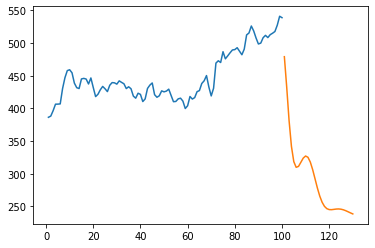

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df1[graph_index:]))     # The last 100 days that we considered (Original values)
plt.plot(day_pred,scaler.inverse_transform(lst_output))           # Our predicted values (Predicted values)

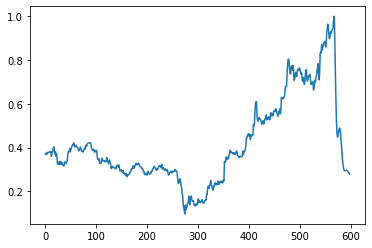

In [ ]:
df3 = df1.tolist()
df3.extend(lst_output)        # Total 2069+30=2099
plt.plot(df3[1500:])          # 2069-1500=569 |||| 569+30=599

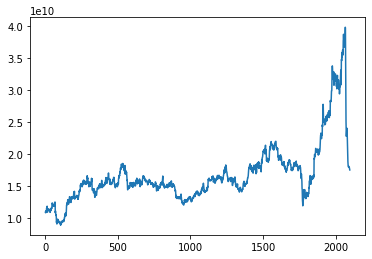

In [ ]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)